In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("/home/sebastian/Documents/Hauptprojekt/Daten_Donut2")

Resolving data files:   0%|          | 0/10390 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3755 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 10389
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 250
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 3754
    })
})

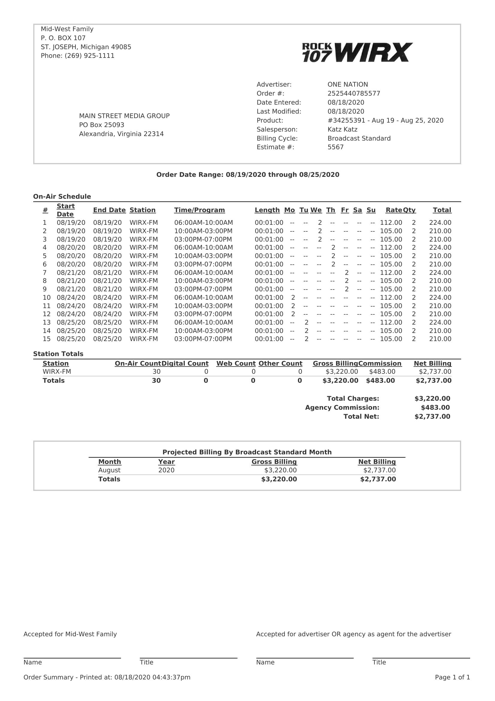

In [4]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [5]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"field_extractions": [{"fieldtype": "document_id", "text": "2525440785577"}, {"fieldtype": "date_issue", "text": "2020-08-18"}, {"fieldtype": "vendor_name", "text": "Mid-West Family"}, {"fieldtype": "vendor_address", "text": "Mid-West Family\nP. O. BOX 107\nST. JOSEPH, Michigan 49085"}, {"fieldtype": "customer_billing_name", "text": "MAIN STREET MEDIA GROUP"}, {"fieldtype": "customer_billing_address", "text": "MAIN STREET MEDIA GROUP\nPO Box 25093\nAlexandria, Virginia 22314"}, {"fieldtype": "currency_code_amount_due", "text": "$"}, {"fieldtype": "amount_total_gross", "text": "$3,220.00"}, {"fieldtype": "amount_total_gross", "text": "$3,220.00"}, {"fieldtype": "amount_total_gross", "text": "$3,220.00"}, {"fieldtype": "amount_due", "text": "$2,737.00"}, {"fieldtype": "amount_due", "text": "$2,737.00"}, {"fieldtype": "amount_due", "text": "$2,737.00"}], "line_item_extractions": [{"fieldtype": "line_item_position", "line_item_id": 1, "text": "1"}, {"fieldtype": "line_item_da

In [6]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'field_extractions': [{'fieldtype': 'document_id', 'text': '2525440785577'},
  {'fieldtype': 'date_issue', 'text': '2020-08-18'},
  {'fieldtype': 'vendor_name', 'text': 'Mid-West Family'},
  {'fieldtype': 'vendor_address',
   'text': 'Mid-West Family\nP. O. BOX 107\nST. JOSEPH, Michigan 49085'},
  {'fieldtype': 'customer_billing_name', 'text': 'MAIN STREET MEDIA GROUP'},
  {'fieldtype': 'customer_billing_address',
   'text': 'MAIN STREET MEDIA GROUP\nPO Box 25093\nAlexandria, Virginia 22314'},
  {'fieldtype': 'currency_code_amount_due', 'text': '$'},
  {'fieldtype': 'amount_total_gross', 'text': '$3,220.00'},
  {'fieldtype': 'amount_total_gross', 'text': '$3,220.00'},
  {'fieldtype': 'amount_total_gross', 'text': '$3,220.00'},
  {'fieldtype': 'amount_due', 'text': '$2,737.00'},
  {'fieldtype': 'amount_due', 'text': '$2,737.00'},
  {'fieldtype': 'amount_due', 'text': '$2,737.00'}],
 'line_item_extractions': [{'fieldtype': 'line_item_position',
   'line_item_id': 1,
   'text': '1'},
  {

In [7]:
from transformers import VisionEncoderDecoderConfig

image_size = [1280, 960]
max_length = 768

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length

In [8]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

2023-09-14 12:30:33.309141: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 12:30:33.347619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 12:30:33.943299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [9]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.
    
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).
    
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

In [10]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset("/home/sebastian/Documents/Hauptprojekt/Daten_Donut2", max_length=max_length,
                             split="train", task_start_token="<s_docile>", prompt_end_token="<s_docile>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("/home/sebastian/Documents/Hauptprojekt/Daten_Donut2", max_length=max_length,
                             split="validation", task_start_token="<s_docile>", prompt_end_token="<s_docile>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Resolving data files:   0%|          | 0/10390 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3755 [00:00<?, ?it/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 57527. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 57529. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means th

Resolving data files:   0%|          | 0/10390 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3755 [00:00<?, ?it/s]

In [11]:
len(added_tokens)

14

In [12]:
print(added_tokens)

['<s_field_extractions>', '</s_field_extractions>', '<s_fieldtype>', '</s_fieldtype>', '<s_text>', '</s_text>', '<s_line_item_extractions>', '</s_line_item_extractions>', '<s_line_item_id>', '</s_line_item_id>', '<s_line_item_headers>', '</s_line_item_headers>', '<s_docile>', '<s_docile>']


In [13]:
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

Original number of tokens: 57522
Number of tokens after adding special tokens: 57538


In [14]:
processor.decode([57530])

'</s_text>'

In [15]:
pixel_values, labels, target_sequence = train_dataset[0]

In [16]:
print(pixel_values.shape)

torch.Size([3, 1280, 960])


In [17]:
# let's print the labels (the first 30 token ID's)
for id in labels.tolist()[:30]:
    if id != -100:
        print(processor.decode([id]))
    else:
        print(id)

<s_field_extractions>
<s_fieldtype>
document
_
id
</s_fieldtype>
<s_text>
25
25
4
40
785
5
77
</s_text>
<sep/>
<s_fieldtype>
date
_
is
su
e
</s_fieldtype>
<s_text>
2020
-08
-18
</s_text>
<sep/>
<s_fieldtype>


In [18]:
print(target_sequence)

<s_field_extractions><s_fieldtype>document_id</s_fieldtype><s_text>2525440785577</s_text><sep/><s_fieldtype>date_issue</s_fieldtype><s_text>2020-08-18</s_text><sep/><s_fieldtype>vendor_name</s_fieldtype><s_text>Mid-West Family</s_text><sep/><s_fieldtype>vendor_address</s_fieldtype><s_text>Mid-West Family
P. O. BOX 107
ST. JOSEPH, Michigan 49085</s_text><sep/><s_fieldtype>customer_billing_name</s_fieldtype><s_text>MAIN STREET MEDIA GROUP</s_text><sep/><s_fieldtype>customer_billing_address</s_fieldtype><s_text>MAIN STREET MEDIA GROUP
PO Box 25093
Alexandria, Virginia 22314</s_text><sep/><s_fieldtype>currency_code_amount_due</s_fieldtype><s_text>$</s_text><sep/><s_fieldtype>amount_total_gross</s_fieldtype><s_text>$3,220.00</s_text><sep/><s_fieldtype>amount_total_gross</s_fieldtype><s_text>$3,220.00</s_text><sep/><s_fieldtype>amount_total_gross</s_fieldtype><s_text>$3,220.00</s_text><sep/><s_fieldtype>amount_due</s_fieldtype><s_text>$2,737.00</s_text><sep/><s_fieldtype>amount_due</s_fieldt

In [19]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_docile>'])[0]

In [20]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_docile>


In [21]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [22]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [23]:
for id in labels.squeeze().tolist():
    if id != -100:
        print(processor.decode([id]))
    else:
        print(id)

<s_field_extractions>
<s_fieldtype>
cur
ren
cy
_
code
_
a
mount
_
du
e
</s_fieldtype>
<s_text>
$
</s_text>
<sep/>
<s_fieldtype>
document
_
id
</s_fieldtype>
<s_text>

438
225
</s_text>
<sep/>
<s_fieldtype>
customer
_
bil
ling
_
ad
dre
s
s
</s_fieldtype>
<s_text>
Eugen
ie
Brad
ford
13
98
Mary
land
Free
way
Central
Falls
,

LK
,
5
87
55
</s_text>
<sep/>
<s_fieldtype>
date
_
is
su
e
</s_fieldtype>
<s_text>
07
/
06
/20
</s_text>
<sep/>
<s_fieldtype>
amount
_
du
e
</s_fieldtype>
<s_text>
$
23
58
</s_text>
<sep/>
<s_fieldtype>
vend
or
_
name
</s_fieldtype>
<s_text>
Tan
ner
Gent
ry
</s_text>
<sep/>
<s_fieldtype>
vend
or
_
ad
dre
s
s
</s_fieldtype>
<s_text>
Tan
ner
Gent
ry
4
29
Letter
man
Ran
ch
West
on
,
9
25
32
</s_text>
<sep/>
<s_fieldtype>
customer
_
bil
ling
_
name
</s_fieldtype>
<s_text>
Eugen
ie
Brad
ford
</s_text>
<sep/>
<s_fieldtype>
amount
_
to
tal
_
gros
s
</s_fieldtype>
<s_text>
$
37
2
0.5
</s_text>
</s_field_extractions>
<s_line_item_extractions>
<s_fieldtype>
line
_
it
em
_
de
sc

In [24]:
# let's check the first validation batch
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [25]:
print(target_sequences[0])

<s_field_extractions><s_fieldtype>document_id</s_fieldtype><s_text>3897</s_text><sep/><s_fieldtype>date_issue</s_fieldtype><s_text>26/02/99</s_text><sep/><s_fieldtype>vendor_name</s_fieldtype><s_text>TANZANIA CIGARETTE COMPANY LTD.</s_text><sep/><s_fieldtype>vendor_address</s_fieldtype><s_text>TANZANIA CIGARETTE COMPANY LTD.
P.O Box 40114 DAR ES SALAAM</s_text><sep/><s_fieldtype>customer_billing_name</s_fieldtype><s_text>R.J. REYNOLDS TOBACCO CO.
BOWMAN GRAY TECHNICAL CENTER</s_text><sep/><s_fieldtype>customer_billing_address</s_fieldtype><s_text>R.J. REYNOLDS TOBACCO CO.
BOWMAN GRAY TECHNICAL CENTER
950 REYNOLDS BLVD
WINSTON - SALEM
N.C. 27105
U.S.A.
ATTN: RONNIE HARTMAN/611-9</s_text><sep/><s_fieldtype>currency_code_amount_due</s_fieldtype><s_text>$</s_text></s_field_extractions><s_line_item_extractions><s_fieldtype>line_item_quantity</s_fieldtype><s_line_item_id>1</s_line_item_id><s_text>930</s_text><sep/><s_fieldtype>line_item_units_of_measure</s_fieldtype><s_line_item_id>1</s_line

In [26]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                #print(f"Prediction: {pred}")
                #print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        
        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [27]:
epochs = 10
config = {"max_epochs":epochs,
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 10389,
          "lr":3e-5,
          "train_batch_sizes": [6],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 225, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

In [28]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

wandb_logger = WandbLogger(project="Donut", name="Docile10epochs_10389train_250val_3e-9lr")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("ZaNioxX/Donut_infoext_10_5_" + str(trainer.current_epoch) + "epochs_10389train_250val_3e-9lr",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")
            

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("ZaNioxX/Donut_infoext_10_5_10epochs_10389train_250val_3e-9lr",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("ZaNioxX/Donut_infoext_10_5_10epochs_10389train_250val_3e-9lr",
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=8, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: sebastian-strobel. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
------

Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/utils.py:1411: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.1812617702448211


/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


 Normed ED: 0.4669909659485754
 Normed ED: 0.18546845124282982
 Normed ED: 0.36518324607329844
 Normed ED: 0.44024337244676226
 Normed ED: 0.2775297619047619
 Normed ED: 0.42012987012987013
 Normed ED: 0.30191854594412654
 Normed ED: 0.27964386887899634
 Normed ED: 0.8003367813326918
 Normed ED: 0.2895437262357414
 Normed ED: 0.2220026350461133
 Normed ED: 0.24486057398738043
 Normed ED: 0.20392953929539295
 Normed ED: 0.2754645560908465
 Normed ED: 0.006797583081570997
 Normed ED: 0.36777777777777776
 Normed ED: 0.0026613439787092482
 Normed ED: 0.015739769150052464
 Normed ED: 0.21361867704280155
 Normed ED: 0.4077314667515113
 Normed ED: 0.8015877003466814
 Normed ED: 0.41898332009531375
 Normed ED: 0.0005303632988597189
 Normed ED: 0.574757281553398
 Normed ED: 0.12931885488647582
 Normed ED: 0.010466222645099905
 Normed ED: 0.012138188608776844
 Normed ED: 0.01599247412982126
 Normed ED: 0.3526479750778816
 Normed ED: 0.5336594456091311
 Normed ED: 0.7217138103161398
 Normed ED: 0

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.2618421052631579
 Normed ED: 0.2497339482085846
 Normed ED: 0.014340344168260038
 Normed ED: 0.14336917562724014
 Normed ED: 0.4495147037519919
 Normed ED: 0.16576487948844074
 Normed ED: 0.2649350649350649
 Normed ED: 0.284079434533827
 Normed ED: 0.19668150546337515
 Normed ED: 0.7845965770171149
 Normed ED: 0.7606463878326997
 Normed ED: 0.4176548089591568
 Normed ED: 0.27498473437818033
 Normed ED: 0.2302158273381295
 Normed ED: 0.23589125946317963
 Normed ED: 0.004531722054380665
 Normed ED: 0.35777777777777775
 Normed ED: 0.0006653359946773121
 Normed ED: 0.011046817464492372
 Normed ED: 0.017120622568093387
 Normed ED: 0.42857142857142855
 Normed ED: 0.7989750288901171
 Normed ED: 0.41739475774424145
 Normed ED: 0.0007955449482895784
 Normed ED: 0.574368932038835
 Normed ED: 0.09272727272727273
 Normed ED: 0.009514747859181731
 Normed ED: 0.011204481792717087
 Normed ED: 0.011288805268109126
 Normed ED: 0.012287334593572778
 Normed ED: 0.5201490798975076
 Normed ED

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the enviro

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.5398659579385255
 Normed ED: 0.8148245845423371
 Normed ED: 0.43986254295532645
 Normed ED: 0.14209591474245115
 Normed ED: 0.4474866000289729
 Normed ED: 0.0886964661830096
 Normed ED: 0.287012987012987
 Normed ED: 0.28929653315382026
 Normed ED: 0.12670349907918968
 Normed ED: 0.3161764705882353
 Normed ED: 0.8986692015209126
 Normed ED: 0.18050065876152832
 Normed ED: 0.919397516792184
 Normed ED: 0.15089163237311384
 Normed ED: 0.22677219545767377
 Normed ED: 0.004531722054380665
 Normed ED: 0.355
 Normed ED: 0.000998003992015968
 Normed ED: 0.004208311415044713
 Normed ED: 0.006614785992217899
 Normed ED: 0.3650970410435889
 Normed ED: 0.7966638195246948
 Normed ED: 0.41540905480540113
 Normed ED: 0.0005303632988597189
 Normed ED: 0.5742718446601942
 Normed ED: 0.002303389272787101
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.010338345864661654
 Normed ED: 0.012287334593572778
 Normed ED: 0.5096668996040066
 Normed ED: 0.71124514697

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the enviro

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.29403606102635227
 Normed ED: 0.959914863426747
 Normed ED: 0.06883365200764818
 Normed ED: 0.0718562874251497
 Normed ED: 0.455743879472693
 Normed ED: 0.15742690058479533
 Normed ED: 0.3226744186046512
 Normed ED: 0.3074722315718613
 Normed ED: 0.12106918238993711
 Normed ED: 0.20756172839506173
 Normed ED: 0.3361216730038023
 Normed ED: 0.7160737812911726
 Normed ED: 0.2084266232444535
 Normed ED: 0.0014925373134328358
 Normed ED: 0.262388162422574
 Normed ED: 0.004528301886792453
 Normed ED: 0.35125
 Normed ED: 0.001996007984031936
 Normed ED: 0.003156233561283535
 Normed ED: 0.011673151750972763
 Normed ED: 0.3773464842507159
 Normed ED: 0.7963121137516957
 Normed ED: 0.4144823934339423
 Normed ED: 0.0005303632988597189
 Normed ED: 0.5740776699029126
 Normed ED: 0.002303389272787101
 Normed ED: 0.008563273073263558
 Normed ED: 0.01027077497665733
 Normed ED: 0.008466603951081843
 Normed ED: 0.008514664143803218
 Normed ED: 0.5101327742837177
 Normed ED: 0.71013588463

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.3300376647834275
 Normed ED: 0.4657680028378858
 Normed ED: 0.0057361376673040155
 Normed ED: 0.11978221415607986
 Normed ED: 0.4773286976676807
 Normed ED: 0.07690487458589683
 Normed ED: 0.3059244126659857
 Normed ED: 0.33826994278020867
 Normed ED: 0.1225153595952295
 Normed ED: 0.06416131989000917
 Normed ED: 0.30133079847908745
 Normed ED: 0.2779973649538867
 Normed ED: 0.2157541217178913
 Normed ED: 0.17852684144818975
 Normed ED: 0.22814865794907088
 Normed ED: 0.004531722054380665
 Normed ED: 0.35055555555555556
 Normed ED: 0.00033266799733865603
 Normed ED: 0.004208311415044713
 Normed ED: 0.056436739210623386
 Normed ED: 0.3676423798918231
 Normed ED: 0.7962618700698387
 Normed ED: 0.4144823934339423
 Normed ED: 0.0005303632988597189
 Normed ED: 0.9112621359223301
 Normed ED: 0.002303389272787101
 Normed ED: 0.008563273073263558
 Normed ED: 0.009328358208955223
 Normed ED: 0.008466603951081843
 Normed ED: 0.008514664143803218
 Normed ED: 0.5167714884696016
 Norm

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.25252525252525254
 Normed ED: 0.3282051282051282
 Normed ED: 0.08317399617590822
 Normed ED: 0.15461847389558234
 Normed ED: 0.45632333767926986
 Normed ED: 0.16897506925207756
 Normed ED: 0.3999197753710389
 Normed ED: 0.26994278020868395
 Normed ED: 0.09748781402324709
 Normed ED: 0.05013673655423884
 Normed ED: 0.661787072243346
 Normed ED: 0.055994729907773384
 Normed ED: 0.24730307347852637
 Normed ED: 0.25418060200668896
 Normed ED: 0.2259119064005506
 Normed ED: 0.0037764350453172208
 Normed ED: 0.3497222222222222
 Normed ED: 0.00033266799733865603
 Normed ED: 0.004208311415044713
 Normed ED: 0.003501945525291829
 Normed ED: 0.3588927776010181
 Normed ED: 0.7961613827061247
 Normed ED: 0.41329097167063805
 Normed ED: 0.0005303632988597189
 Normed ED: 0.5740776699029126
 Normed ED: 0.0019743336623889436
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.010348071495766699
 Normed ED: 0.008514664143803218
 Normed ED: 0.514907989750757
 No

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the enviro

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.23759791122715404
 Normed ED: 0.3082653423199716
 Normed ED: 0.0057361376673040155
 Normed ED: 0.006147540983606557
 Normed ED: 0.4613935969868173
 Normed ED: 0.07415304430229804
 Normed ED: 0.2977346278317152
 Normed ED: 0.280713564456412
 Normed ED: 0.08903278025091056
 Normed ED: 0.23978685612788633
 Normed ED: 0.32547528517110264
 Normed ED: 0.037549407114624504
 Normed ED: 0.16242621616120498
 Normed ED: 0.061052631578947365
 Normed ED: 0.2259119064005506
 Normed ED: 0.0037764350453172208
 Normed ED: 0.3526388888888889
 Normed ED: 0.00033266799733865603
 Normed ED: 0.003682272488164124
 Normed ED: 0.0038910505836575876
 Normed ED: 0.36223353483932547
 Normed ED: 0.798171129980405
 Normed ED: 0.41501191421763306
 Normed ED: 0.0005303632988597189
 Normed ED: 0.574368932038835
 Normed ED: 0.0019743336623889436
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.008466603951081843
 Normed ED: 0.008514664143803218
 Normed ED: 0.5262054507337526

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the enviro

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.06471631205673758
 Normed ED: 0.9602695991486343
 Normed ED: 0.08508604206500955
 Normed ED: 0.14209591474245115
 Normed ED: 0.4631319716065479
 Normed ED: 0.09881796690307329
 Normed ED: 0.21751101321585903
 Normed ED: 0.2647256815886907
 Normed ED: 0.11698841698841698
 Normed ED: 0.1965648854961832
 Normed ED: 0.3015209125475285
 Normed ED: 0.1297760210803689
 Normed ED: 0.1929574598005292
 Normed ED: 0.06938483547925609
 Normed ED: 0.2259119064005506
 Normed ED: 0.004531722054380665
 Normed ED: 0.3611111111111111
 Normed ED: 0.003654485049833887
 Normed ED: 0.003682272488164124
 Normed ED: 0.0038910505836575876
 Normed ED: 0.40200445434298443
 Normed ED: 0.7961111390242677
 Normed ED: 0.4126290706910246
 Normed ED: 0.0007953340402969247
 Normed ED: 0.5737864077669903
 Normed ED: 0.002303389272787101
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.008466603951081843
 Normed ED: 0.00945179584120983
 Normed ED: 0.5112974609829956
 Normed ED

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the enviro

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.09936034115138592
 Normed ED: 0.38275984391628237
 Normed ED: 0.0124282982791587
 Normed ED: 0.00205761316872428
 Normed ED: 0.4361871650007243
 Normed ED: 0.11691312384473197
 Normed ED: 0.4629333333333333
 Normed ED: 0.2950185122854258
 Normed ED: 0.08336705787130716
 Normed ED: 0.2467924528301887
 Normed ED: 0.2661596958174905
 Normed ED: 0.08739708676377454
 Normed ED: 0.1892937105638103
 Normed ED: 0.04918032786885246
 Normed ED: 0.229525120440468
 Normed ED: 0.0037764350453172208
 Normed ED: 0.37916666666666665
 Normed ED: 0.02162341982701264
 Normed ED: 0.06417674907943188
 Normed ED: 0.002723735408560311
 Normed ED: 0.35491568565065224
 Normed ED: 0.7960106516605537
 Normed ED: 0.41329097167063805
 Normed ED: 0.0005303632988597189
 Normed ED: 0.5742718446601942
 Normed ED: 0.0019743336623889436
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.008466603951081843
 Normed ED: 0.00945179584120983
 Normed ED: 0.5122292103424179
 Normed ED

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


 Normed ED: 0.15269339813689753
 Normed ED: 0.34231997162114225
 Normed ED: 0.0124282982791587
 Normed ED: 0.00205761316872428
 Normed ED: 0.4631319716065479
 Normed ED: 0.12315616951533599
 Normed ED: 0.3805309734513274
 Normed ED: 0.2714574217435207
 Normed ED: 0.17809187279151945
 Normed ED: 0.07308377896613191
 Normed ED: 0.264638783269962
 Normed ED: 0.07020872865275142
 Normed ED: 0.214125788723794
 Normed ED: 0.8284543325526932
 Normed ED: 0.2255677907777013
 Normed ED: 0.0037764350453172208
 Normed ED: 0.3561111111111111
 Normed ED: 0.0006653359946773121
 Normed ED: 0.003682272488164124
 Normed ED: 0.003501945525291829
 Normed ED: 0.3577791918549157
 Normed ED: 0.7957594332512686
 Normed ED: 0.4130262112787927
 Normed ED: 0.0005303632988597189
 Normed ED: 0.574368932038835
 Normed ED: 0.0019743336623889436
 Normed ED: 0.008563273073263558
 Normed ED: 0.008403361344537815
 Normed ED: 0.008466603951081843
 Normed ED: 0.00945179584120983
 Normed ED: 0.5102492429536455
 Normed ED: 

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Pushing model to the hub after training


sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## evaluate model

In [58]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np
epochs = 10

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model = VisionEncoderDecoderModel.from_pretrained("ZaNioxX/Donut_infoext_10_5_10epochs_10389train_250val_3e-9lr")

model.eval()
model.to(device)

output_list = []
accs = []

dataset = load_dataset("/home/sebastian/Documents/Hauptprojekt/Daten_Donut2", split="validation")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_docile>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

Resolving data files:   0%|          | 0/10390 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/3755 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


{'accuracies': [0.7194513715710723, 0.5732177263969171, 0.9708520179372198, 0.9916666666666667, 0.5590931017848528, 0.7287319422150883, 0.32335329341317365, 0.9386391251518833, 0.829121540312876, 0.921875, 0.5780206435944141, 0.8827586206896552, 0.7169435215946844, 0.17831325301204815, 0.8930180180180181, 0.9906716417910448, 0.7957639939485628, 0.9954022988505747, 0.9798449612403101, 0.983127109111361, 0.891578947368421, 0.35530892827563354, 0.8479284369114878, 0.9891402714932127, 0.6705921938088829, 0.9877551020408163, 0.9800443458980045, 0.9808917197452229, 0.980561555075594, 0.9781181619256017, 0.7563155849203265, 0.5133627701603533, 0.9435626102292769, 0.9840925524222705, 0.7496665184526456, 0.9753787878787878, 0.9722543352601156, 0.9744816586921851, 0.9911971830985915, 0.9887387387387387, 0.9843260188087775, 0.6756509821836455, 0.9849354375896701, 0.6134524141780631, 0.549818587775607, 0.9794628751974723, 0.6768149882903981, 0.8874931731294374, 0.9722405816259088, 0.64279155188246

In [59]:
np.save("/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/" + str(epochs) + "epochs_accuracies_10389train_3754test_250val_3e-9lr", accs)

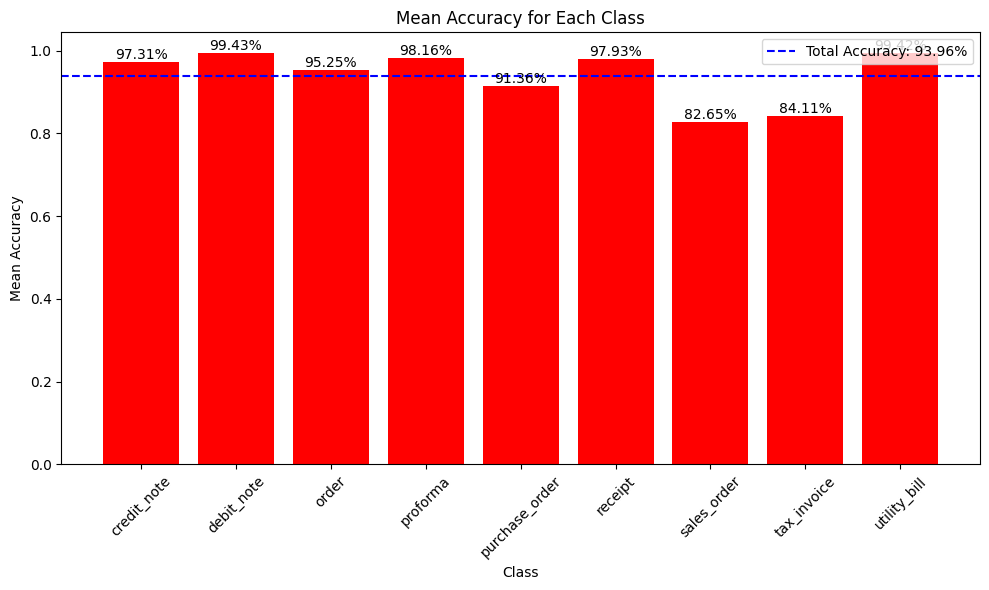

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

file_path = "/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_after.pkl"
with open(file_path, 'rb') as file:
    model_accuracies = pickle.load(file)

file_path = "/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_before.pkl"
with open(file_path, 'wb') as file:
    pickle.dump(model_accuracies, file)


# Define your predictions and true_labels arrays (assuming they are NumPy arrays)
predictions = np.load("/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/" + str(epochs) + "epochs_accuracies_10389train_3754test_250val_3e-9lr.npy")
true_labels = np.load("/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/vallabels.npy")

# Create a dictionary to store the mean accuracy and count for each class
class_accuracy = defaultdict(lambda: {'accuracy': 0, 'count': 0})

# Calculate accuracy for each class and count occurrences
for class_name in np.unique(true_labels):
    indices = np.where(true_labels == class_name)
    class_predictions = predictions[indices]
    accuracy = np.mean(class_predictions)
    count = len(class_predictions)
    class_accuracy[class_name]['accuracy'] = accuracy
    class_accuracy[class_name]['count'] = count

# Calculate the total accuracy by averaging all class accuracies
total_accuracy = np.mean([v['accuracy'] for v in class_accuracy.values()])
model_name = str(epochs) + "epochs_accuracies_10389train_3754test_250val_3e-9lr"
model_accuracies[model_name] = total_accuracy


# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_accuracy.keys(), [v['accuracy'] for v in class_accuracy.values()], color='red')
plt.axhline(total_accuracy, color='blue', linestyle='--', label=f'Total Accuracy: {total_accuracy:.2%}')
plt.title('Mean Accuracy for Each Class')
plt.xlabel('Class')
plt.ylabel('Mean Accuracy')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add percentage labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom')

# Display the plot
plt.legend()
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/InformationExtraction/' + str(epochs) + 'epochs_accuracies_10389train_3754test_250val_3e-9lr.png', bbox_inches='tight')

plt.show()


In [61]:
file_path = "/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_after.pkl"
with open(file_path, 'wb') as file:
    pickle.dump(model_accuracies, file)

print(f"Model accuracy dictionary saved to {file_path}")

Model accuracy dictionary saved to /home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_after.pkl


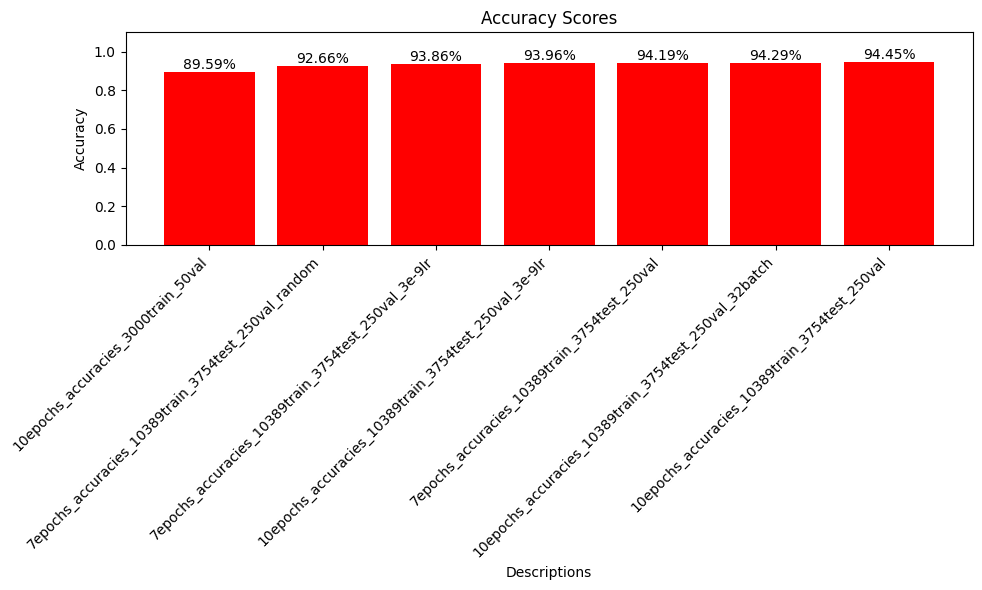

In [70]:
import matplotlib.pyplot as plt

file_path = "/home/sebastian/Documents/Hauptprojekt/Arrays/DonutInfoExtraction/model_accuracies_after.pkl"
with open(file_path, 'rb') as file:
    data = pickle.load(file)

data = dict(sorted(data.items(), key=lambda item: item[1]))


# Extract the keys (descriptions) and values (accuracy scores) from the dictionary
descriptions = list(data.keys())
accuracies = list(data.values())

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
bars = plt.bar(descriptions, accuracies, color='red')
plt.xlabel('Descriptions')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.ylim(0, 1.1)

# Add accuracy values as text labels above the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2%}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/InformationExtraction/DonutModelAccuracies.png', bbox_inches='tight')

plt.show()
